## TensorFlow - GANs
**GANs (Generative Adversarial Networks)** in a deep learning architecture for generating new data with the same distributions as training data. In this sheet we will train a **GAN** as described in the original paper of Ian Godfellow et. al.

https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf

In a GAN two neural networks are trained together, a **generator** network and a **discriminator** network. **Generator** network takes random noise and generates images from it, and **discriminator** network learns how to distinguish between fake and real images. Discriminator network is like any other classification network which detects fakes from real images. Generator network is trained in a unique way, for training Generator network two things are done, we freeze the weights of the discriminator (its as if the cops intelligence is held constant) and we label fake images as real. Now if the generator generates a really good fake discriminator wont be able to detect it and will take it as real and the loss would be very small. On the other hand if the generator makes a very bad fake discriminator would easily detect it and mark it as fake and loss would be very large. 

Training these two together discriminator becomes better at detecting fakes and generator becomes better at making fakes.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import sys, os

In [2]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


In [3]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [4]:
# Dimensionality of the latent space
latent_dim = 100

In [5]:
# build the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

In [6]:
# build the discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

In [7]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [8]:
batch_size = 32
epochs = 5000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [9]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
        idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [10]:
# Main training loop
for epoch in range(epochs):
    ###########################
    ### Train discriminator ###
    ###########################
  
    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
  
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
  
    # Train the discriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
    #######################
    ### Train generator ###
    #######################
  
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
  
    # do it again!
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
  
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
  
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
        d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
    if epoch % sample_period == 0:
        print(f"Saving image")
        sample_images(epoch)


epoch: 1/5000, d_loss: 0.98,         d_acc: 0.42, g_loss: 0.74
Saving image
epoch: 101/5000, d_loss: 0.03,         d_acc: 1.00, g_loss: 3.49
epoch: 201/5000, d_loss: 0.83,         d_acc: 0.45, g_loss: 0.91
Saving image
epoch: 301/5000, d_loss: 0.71,         d_acc: 0.50, g_loss: 0.60
epoch: 401/5000, d_loss: 0.72,         d_acc: 0.47, g_loss: 0.62
Saving image
epoch: 501/5000, d_loss: 0.69,         d_acc: 0.48, g_loss: 0.64
epoch: 601/5000, d_loss: 0.68,         d_acc: 0.48, g_loss: 0.66
Saving image
epoch: 701/5000, d_loss: 0.67,         d_acc: 0.48, g_loss: 0.69
epoch: 801/5000, d_loss: 0.70,         d_acc: 0.52, g_loss: 0.72
Saving image
epoch: 901/5000, d_loss: 0.67,         d_acc: 0.59, g_loss: 0.73
epoch: 1001/5000, d_loss: 0.67,         d_acc: 0.50, g_loss: 0.75
Saving image
epoch: 1101/5000, d_loss: 0.63,         d_acc: 0.64, g_loss: 0.77
epoch: 1201/5000, d_loss: 0.63,         d_acc: 0.66, g_loss: 0.75
Saving image
epoch: 1301/5000, d_loss: 0.63,         d_acc: 0.64, g_loss: 0.

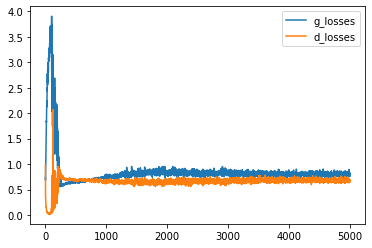

In [11]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

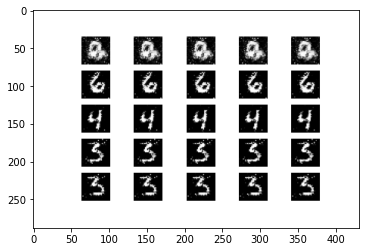

In [12]:
from skimage.io import imread
a = imread('gan_images/4800.png')
plt.imshow(a)

We get pretty realistic images from the GAN.